In [1]:
import numpy as np
import pandas as pd 
import random
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches 
from matplotlib.collections import PatchCollection



In [2]:
class Node():
    
    def __init__(
        self, center, radius, label, 
        facecolor='#2693de', edgecolor='#e6e6e6',
        ring_facecolor='#a3a3a3', ring_edgecolor='#a3a3a3'
        ):
        """
        Initializes a Markov Chain Node(for drawing purposes)
        Inputs:
            - center : Node (x,y) center
            - radius : Node radius
            - label  : Node label
        """
        self.center = center
        self.radius = radius
        self.label  = label

        # For convinience: x, y coordinates of the center
        self.x = center[0]
        self.y = center[1]
        
        # Drawing config
        self.node_facecolor = facecolor
        self.node_edgecolor = edgecolor
        
        self.ring_facecolor = ring_facecolor
        self.ring_edgecolor = ring_edgecolor
        self.ring_width = 0.03  
        
        self.text_args = {
            'ha': 'center', 
            'va': 'center', 
            'fontsize': 16
        }
    
    
    def add_circle(self, ax):
        """
        Add the annotated circle for the node
        """
        circle = mpatches.Circle(self.center, self.radius)
        p = PatchCollection(
            [circle], 
            edgecolor = self.node_edgecolor, 
            facecolor = self.node_facecolor
        )
        ax.add_collection(p)
        ax.annotate(
            self.label, 
            xy = self.center, 
            color = '#ffffff', 
            **self.text_args
        )
        
        
    def add_self_loop(self, ax, prob=None, direction='up'):
        """
        Draws a self loop
        """
        if direction == 'up':
            start = -30
            angle = 180
            ring_x = self.x
            ring_y = self.y + self.radius
            prob_y = self.y + 1.3*self.radius
            x_cent = ring_x - self.radius + (self.ring_width/2)
            y_cent = ring_y - 0.15
        else:
            start = -210
            angle = 0
            ring_x = self.x
            ring_y = self.y - self.radius
            prob_y = self.y - 1.4*self.radius
            x_cent = ring_x + self.radius - (self.ring_width/2)
            y_cent = ring_y + 0.15
            
        # Add the ring
        ring = mpatches.Wedge(
            (ring_x, ring_y), 
            self.radius, 
            start, 
            angle, 
            width = self.ring_width
        )
        # Add the triangle (arrow)
        offset = 0.2
        left   = [x_cent - offset, ring_y]
        right  = [x_cent + offset, ring_y]
        bottom = [(left[0]+right[0])/2., y_cent]
        arrow  = plt.Polygon([left, right, bottom, left])

        p = PatchCollection(
            [ring, arrow], 
            edgecolor = self.ring_edgecolor, 
            facecolor = self.ring_facecolor
        )
        ax.add_collection(p)
        
        # Probability to add?
        if prob:
            ax.annotate(str(prob), xy=(self.x, prob_y), color='#000000', **self.text_args)


In [3]:
class MarkovChain:

    def __init__(self, M, labels):
        """
        Initializes a Markov Chain (for drawing purposes)
        Inputs:
            - M         Transition Matrix
            - labels    State Labels
        """

        if M.shape[0] < 2:
            raise Exception("There should be at least 2 states")
        if M.shape[0] > 4:
            raise Exception("Only works with 4 states max for now")
        if M.shape[0] != M.shape[1]:
            raise Exception("Transition matrix should be square")
        if M.shape[0] != len(labels):
            raise Exception("There should be as many labels as states")

        self.M = M
        self.n_states = M.shape[0]
        self.labels = labels

        # Colors
        self.arrow_facecolor = '#a3a3a3'
        self.arrow_edgecolor = '#a3a3a3'

        self.node_facecolor = '#2693de'
        self.node_edgecolor = '#e6e6e6'

        # Drawing config
        self.node_radius = 0.5
        self.arrow_width = 0.03
        self.arrow_head_width = 0.20
        self.text_args = {
            'ha': 'center',
            'va': 'center',
            'fontsize': 16
        }

        # Build the network
        self.build_network()


    def set_node_centers(self):
        """
        Positions the node centers given the number of states
        """
        # Node positions
        self.node_centers = []

        if self.n_states == 2:
            self.figsize = (10, 4)
            self.xlim = (-5, 5)
            self.ylim = (-2, 2)
            self.node_centers = [[-4,0], [4,0]]
        elif self.n_states == 3:
            self.figsize = (10, 6)
            self.xlim = (-5, 5)
            self.ylim = (-3, 3)
            self.node_centers = [[-3,-2], [3,-2], [-3,2]]
        elif self.n_states == 4:
            self.figsize = (8, 8)
            self.xlim = (-5, 5)
            self.ylim = (-5, 5)
            self.node_centers = [[-4,4], [4,4], [4,-4], [-4,-4]]


    def build_network(self):
        """
        Loops through the matrix, add the nodes
        """
        # Position the node centers
        self.set_node_centers()

        # Set the nodes
        self.nodes = []
        for i in range(self.n_states):
            node = Node(
                self.node_centers[i],
                self.node_radius,
                self.labels[i]
            )
            self.nodes.append(node)


    def add_arrow(self, ax, node1, node2, prob=None):
        """
        Add a directed arrow between two nodes
        """
        # x,y start of the arrow
        x_start = node1.x + np.sign(node2.x-node1.x) * node1.radius
        y_start = node1.y + np.sign(node2.y-node1.y) * node1.radius

        # arrow length
        dx = abs(node1.x - node2.x) - 2.5* node1.radius
        dy = abs(node1.y - node2.y) - 2.5* node1.radius

        # we don't want xoffset and yoffset to both be non-nul
        yoffset = 0.4 * self.node_radius * np.sign(node2.x-node1.x)
        if yoffset == 0:
            xoffset = 0.4 * self.node_radius * np.sign(node2.y-node1.y)
        else:
            xoffset = 0

        arrow = mpatches.FancyArrow(
            x_start + xoffset,
            y_start + yoffset,
            dx * np.sign(node2.x-node1.x),
            dy * np.sign(node2.y-node1.y),
            width = self.arrow_width,
            head_width = self.arrow_head_width
        )
        p = PatchCollection(
            [arrow],
            edgecolor = self.arrow_edgecolor,
            facecolor = self.arrow_facecolor
        )
        ax.add_collection(p)

        # Probability to add?
        x_prob = x_start + xoffset + 0.2*dx*np.sign(node2.x-node1.x)
        y_prob = y_start + yoffset + 0.2*dy*np.sign(node2.y-node1.y)
        if prob:
            ax.annotate(str(prob), xy=(x_prob, y_prob), color='#000000', **self.text_args)


    def draw(self, img_path=None):
        """
        Draw the Markov Chain
        """
        fig, ax = plt.subplots(figsize=self.figsize)

        # Set the axis limits
        plt.xlim(self.xlim)
        plt.ylim(self.ylim)

        # Draw the nodes
        for node in self.nodes:
            node.add_circle(ax)

        # Add the transitions
        for i in range(self.M.shape[0]):
            for j in range(self.M.shape[1]):
                # self loops
                if i == j:
                    # Loop direction
                    if self.nodes[i].y >= 0:
                        self.nodes[i].add_self_loop(ax, prob = self.M[i,j], direction='up')
                    else:
                        self.nodes[i].add_self_loop(ax, prob = self.M[i,j], direction='down')
                # directed arrows
                elif self.M[i,j] > 0:
                    self.add_arrow(ax, self.nodes[i], self.nodes[j], prob = self.M[i,j])

        plt.axis('off')
        # Save the image to disk?
        if img_path:
            plt.savefig(img_path)
        plt.show()



In [4]:
plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams.update({"font.size" : 14})

In [5]:
def gamblers_ruin():
    gambling_money = 50
    gambling_goal = 100
    gambling_simulations = []
    
    while gambling_money in range(1,gambling_goal):
        bet_size = 1
        w_or_l = random.randrange(-1,2,2)
        gambling_money+= bet_size * w_or_l
        gambling_simulations.append(gambling_money)
    return gambling_simulations

Text(0.5, 1.0, 'Gambling Simulation')

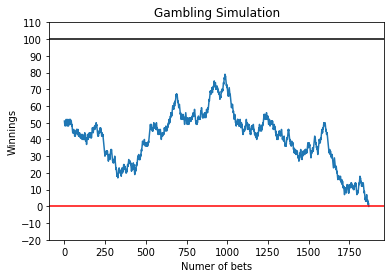

In [6]:
plt.plot(gamblers_ruin())
plt.yticks(np.arange(-20,120,10))
plt.axhline(y=0,color="red",linestyle ="-")
plt.axhline(y=100,color="black",linestyle ="-")
plt.xlabel("Numer of bets")
plt.ylabel("Winnings")
plt.title("Gambling Simulation")

In [7]:
def prob_of_ruin(gambling_goal, initial_gambling_money):
    return (gambling_goal - initial_gambling_money)/gambling_goal



In [8]:
prob_of_ruin(100,50)

0.5

In [9]:
sim_list = []
while len(sim_list) < 500:
    sim_list.append(gamblers_ruin()[-1])
np.mean(sim_list)

53.2

**Markov Chain Simulations**

KeyError: (0, 0)

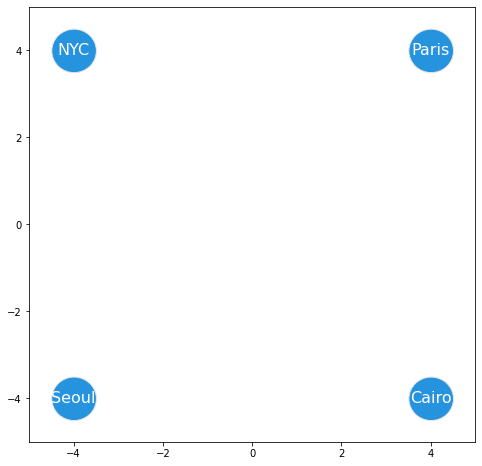

In [10]:
example = {
    "NYC":    [.25,0,.75,1],
    "Paris" : [.25,.25,0,0],
    "Cairo" : [.25,.25,.25,0],
    "Seoul" : [.25,.50,0,0]
}

markov_chain = pd.DataFrame(data=example,index = ["NYC","Paris","Cairo","Seoul"])
markov_chain

markov_chain_image  =  MarkovChain(markov_chain, ["NYC","Paris","Cairo","Seoul"] )
markov_chain_image.draw("./markov_chain.png")


In [ ]:

# from markovchain import MarkovChain
# markov_chain_diagram = MarkovChain(example,["NYC","Paris","Cairo","Seoul"])
# markov_chain_diagram.draw()



In [ ]:
travel_sim = []
travel_sim.append(markov_chain.iloc[0].index[0])
city = np.random.choice(markov_chain.iloc[0].index,p=markov_chain.iloc[0])
travel_sim.append(city)

while len(travel_sim) < 25:
    city = np.random.choice(markov_chain.iloc[markov_chain.index.get_loc(city)].index,p=markov_chain.iloc[markov_chain.index.get_loc(city)])
    travel_sim.append(city)

travel_sim

['NYC',
 'Cairo',
 'Cairo',
 'NYC',
 'NYC',
 'NYC',
 'Seoul',
 'NYC',
 'Cairo',
 'NYC',
 'Cairo',
 'NYC',
 'NYC',
 'Paris',
 'Seoul',
 'NYC',
 'Paris',
 'Seoul',
 'NYC',
 'Cairo',
 'NYC',
 'NYC',
 'Paris',
 'Seoul',
 'NYC']

In [ ]:
markov_chain.to_numpy()

array([[0.25, 0.25, 0.25, 0.25],
       [0.  , 0.25, 0.25, 0.5 ],
       [0.75, 0.  , 0.25, 0.  ],
       [1.  , 0.  , 0.  , 0.  ]])

**n Step Transition Matrix**\n
,in this case it n = 2

In [ ]:
np.dot(markov_chain.to_numpy(),markov_chain.to_numpy())

array([[0.5   , 0.125 , 0.1875, 0.1875],
       [0.6875, 0.0625, 0.125 , 0.125 ],
       [0.375 , 0.1875, 0.25  , 0.1875],
       [0.25  , 0.25  , 0.25  , 0.25  ]])

In [ ]:
def matrix_power(matrix,power):
    if power ==0:
        return np.identity(len(matrix))
    elif power ==1:
        return matrix
    else:
        return np.dot(matrix,matrix_power(matrix,power-1))



In [ ]:
matrix_power(markov_chain,3)

array([[0.453125, 0.15625 , 0.203125, 0.1875  ],
       [0.390625, 0.1875  , 0.21875 , 0.203125],
       [0.46875 , 0.140625, 0.203125, 0.1875  ],
       [0.5     , 0.125   , 0.1875  , 0.1875  ]])

In [ ]:
matrix_power(markov_chain.to_numpy(),3).sum(axis=1)

array([1., 1., 1., 1.])

**Steady State Matrix**

In [ ]:
for i in range(1,10,1):
    print(f'n step Transition Matrix at the nth power {i}\n', matrix_power(markov_chain.to_numpy(),i),'\n')

n step Transition Matrix at the nth power 1
 [[0.25 0.25 0.25 0.25]
 [0.   0.25 0.25 0.5 ]
 [0.75 0.   0.25 0.  ]
 [1.   0.   0.   0.  ]] 

n step Transition Matrix at the nth power 2
 [[0.5    0.125  0.1875 0.1875]
 [0.6875 0.0625 0.125  0.125 ]
 [0.375  0.1875 0.25   0.1875]
 [0.25   0.25   0.25   0.25  ]] 

n step Transition Matrix at the nth power 3
 [[0.453125 0.15625  0.203125 0.1875  ]
 [0.390625 0.1875   0.21875  0.203125]
 [0.46875  0.140625 0.203125 0.1875  ]
 [0.5      0.125    0.1875   0.1875  ]] 

n step Transition Matrix at the nth power 4
 [[0.453125   0.15234375 0.203125   0.19140625]
 [0.46484375 0.14453125 0.19921875 0.19140625]
 [0.45703125 0.15234375 0.203125   0.1875    ]
 [0.453125   0.15625    0.203125   0.1875    ]] 

n step Transition Matrix at the nth power 5
 [[0.45703125 0.15136719 0.20214844 0.18945312]
 [0.45703125 0.15234375 0.20214844 0.18847656]
 [0.45410156 0.15234375 0.203125   0.19042969]
 [0.453125   0.15234375 0.203125   0.19140625]] 

n step Trans

ending up in the state where it started

In [ ]:
initial_dist = np.asarray([1,0,0,0,])
mc_p2 = matrix_power(markov_chain.to_numpy(),2)

np.dot(initial_dist,mc_p2)


array([0.5   , 0.125 , 0.1875, 0.1875])